# Bayesian Learning Lab1

Author : Yunan Dong, Yifan Ding

In [1]:
import numpy as np
import math
from scipy.integrate import quad
import scipy.stats as stats
from scipy.special import *
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

np.random.seed(12345)

# Q1

## a)

By definition, the true value of mean and stand deviation of Beta distribution are:

Theoratical mean value:

$$E(\theta) = \frac{\alpha + s}{\alpha + \beta + s + f} \approx 0.3667 $$

Theoratical standard deviation:
$$Std(\theta) = \sqrt{\frac{(\alpha + s)(\beta + f)}{(\alpha + \beta + s + f)^2 (\alpha + \beta + s + f + 1)}} \approx  0.0866$$

As shown below, with the increasing of samples to sufficiently large numbers, such as samples approximately equal to 400 , the posterior mean and standard deviation keep stable at the calculated mean and std values above.


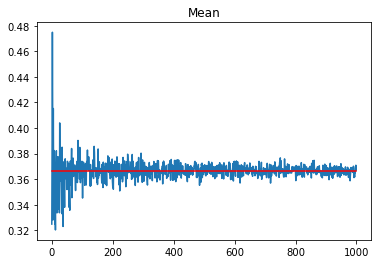

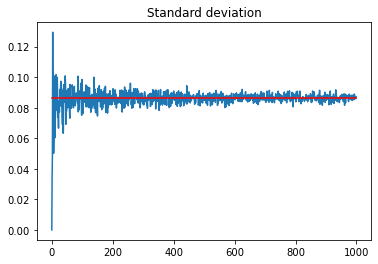

In [2]:
alpha = 3
beta = 3
s = 8
f = 16

# posterior
means, stds = [], []

for i in range(1000):
    samples = np.random.beta(alpha + s, beta + f, size=i+1)
    means.append(np.mean(samples))
    stds.append(np.std(samples))

std = np.sqrt((alpha + s) * (beta + f) / (alpha + beta + s + f)**2 / (alpha + beta + s + f + 1))
mean = (alpha + s) / (alpha + beta + s + f)
    
plt.figure(1)
plt.title('Mean')
plt.plot(np.arange(1000),means)
plt.plot(np.arange(1000),mean * np.ones(1000), color='red')
plt.figure(2)
plt.title('Standard deviation')
plt.plot(np.arange(1000),stds)
plt.plot(np.arange(1000),std * np.ones(1000), color='red')

## b)

When sampling from the posterior, the result is the amount of sampled points which are greater than 0.4, our estimated calculation is 0.341.
And we calculate the exact value as Pr(theta>0.4|y)=1-Pr(theta<=0.4|y): 0.343.


In [3]:
samples = np.random.beta(alpha + s, beta + f, size=10000)
prob_est = len(samples[samples>0.4]) / 10000 
prob_est

0.3409

In [4]:
betacdf = stats.beta(alpha + s, beta + f).cdf
prob_cdf = 1 - betacdf(0.4)
prob_cdf

0.342665361881045

## c)

After putting theta into the functional expression phi, the corresponding visualization from the simulation is shown below.

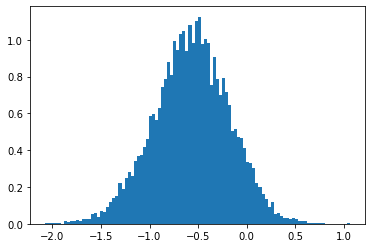

In [5]:
samples = np.random.beta(alpha + s, beta + f, size=10000)
logodds_samples = np.log(samples / (1 - samples))
plt.figure(3)
plt.hist(logodds_samples, density=True, bins=100)
plt.show()

# Q2

## a)

The density graph of the simulation result and the theoretical probability value of the corresponding sampling points are shown below, from which we can see the sampling points’ ratio and the corresponding theoretical values are almost consistently distributed together.

0.32650460106393564


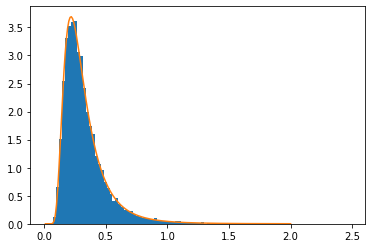

In [6]:
obs = np.array([38, 20, 49, 58, 31, 70, 18, 56, 25, 78])
mu = 3.8
n = len(obs)
tau_squ = np.sum((np.log(obs) - mu) ** 2) / n
# sample from posterior
samplex = tau_squ * n / np.random.chisquare(n, size=10000)

def pdf_invchi(x, v, tau_squ):
    
    y = ((tau_squ * v / 2) ** (v / 2)) / math.gamma(v / 2) * np.exp(-v * tau_squ / 2 / x) / x ** (1 + v / 2)
    return y

# derectly calculate pdf
x = np.arange(0, 2, 0.01) + 0.01
y = pdf_invchi(x, n, tau_squ)

print(np.mean(samplex))
plt.figure(3)
plt.hist(samplex, density=True, bins=100)
plt.plot(x,y)

## b)

The (unnormalized)  sampling result from the simulation of Gini coefficient G has the distribution pattern as below, unimodal and skewed left.

0.3031590822335598

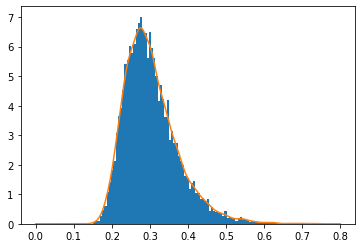

In [7]:
def gini(x):
    cdf_norm = stats.norm(0, 1).cdf
    y = 2 * cdf_norm(np.sqrt(x / 2)) - 1
    return y

trans = gini(samplex)

# Kernel density estimation
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(trans[:, None])

x = np.linspace(0, 0.8, 1000)
logprob = kde.score_samples(x[:, None])
y = np.exp(logprob)

plt.figure(4)
plt.hist(trans, density=True, bins=100)
plt.plot(x, y)
np.mean(trans)

## c)

Since the graph is unimodal, median and mode are not at tails.

The equal tail(including median value) credible interval is [0.211,0.436], which is approximately obtained by sorting and cutting off the first and last 5% of the sampling points

The HPDI(including mode) is,[0.194,0.407], which is obtained by cutting off the first and last 5% of the areas in the density graph generated by density function in R(default set)


The lower bound and higher bound of ETI are 0.21076717621783245 0.43583572533086884 respectively
The lower bound and higher bound of HDI are 0.19352869192134725 0.4072537431184451 respectively


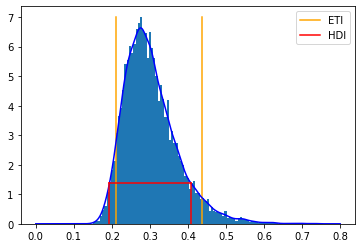

In [8]:
eti_low = np.percentile(trans, 5)
eti_hight = np.percentile(trans, 95)
print('The lower bound and higher bound of ETI are {} {} respectively'.format(eti_low, eti_hight))
    
def HDI_from_sample(posterior_samples, credible_mass):
    sorted_points = sorted(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0]*nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth))+ciIdxInc]
    return(HDImin, HDImax)    

hdi_low, hdi_hight = HDI_from_sample(trans, 0.9)
print('The lower bound and higher bound of HDI are {} {} respectively'.format(hdi_low, hdi_hight))

index = np.argmin(np.abs(hdi_low - x))
hdi_y = y[index]

plt.figure(4)
plt.hist(trans, density=True, bins=100)
plt.plot([eti_low, eti_low], [7, 0], color='orange',label='ETI')
plt.plot([eti_hight, eti_hight], [7, 0], color='orange')
plt.plot(x, y, color='blue')
plt.plot([hdi_low, hdi_low], [hdi_y, 0], color='red',label='HDI')
plt.plot([hdi_hight, hdi_hight], [hdi_y, 0], color='red')
plt.plot([hdi_low, hdi_hight], [hdi_y, hdi_y], color='red')
plt.legend()

# Q3

## a)

The posterior is :
$$p(\kappa|y) = \frac{p(y|\kappa)p(\kappa)}{\int p(y|\kappa)p(\kappa)d\kappa}$$

$$p(\kappa|y) \propto p(y|\kappa)p(\kappa) = \frac{exp(\kappa \sum cos(y_i - \mu) - \kappa)}{I_0 (\kappa)^n}$$
$\int p(y|\kappa)p(\kappa)d\kappa$ is a constant, we calculate this constant C by using numerical integral from scipy, it is also possible to use other numerical methods like MCMC or variational inference.



In [9]:
# Calculate posterior Constant
def calculateC(k):
    mu=2.39
    x = np.array([-2.44, 2.14,2.54,1.83,2.02,2.33,-2.79,2.23,2.07,2.02])
    n = len(x)
    y = np.exp(k * (np.sum(np.cos(x - mu)) - 1)) / (iv(0, k) ** n)
    return y

C, err = quad(calculateC, 0, 20)
C

965.6460488998484

In [10]:
direction = np.array([-2.44, 2.14,2.54,1.83,2.02,2.33,-2.79,2.23,2.07,2.02])
k = np.arange(0, 10, 0.01) + 0.01

def posterior(x, k, C, mu=2.39):
    n = len(x)
    y = np.exp(k * (np.sum(np.cos(x - mu)) - 1)) / (iv(0, k) ** n) / C
    return y

y = posterior(direction, k, C=C)

## b)

The mode, as the statistic with the highest density(probability), is  2.120

Mode : 2.1199999999999997


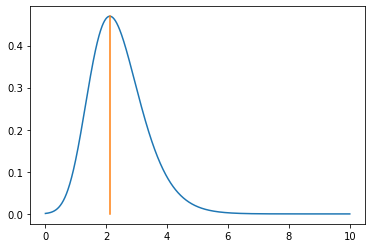

In [11]:
index = np.argmax(y)
print('Mode : {}'.format(k[index]))
plt.figure(5)
plt.plot(k, y)
plt.plot([k[index], k[index]], [posterior(direction, k[index], C=C), 0])